# Score-Based Generative Modeling on Swiss Roll – A Diffusion Perspective

This notebook presents a pedagogical implementation of score-based generative models using stochastic differential equations (SDEs), applied to a synthetic 2D dataset: the Swiss Roll.

The approach follows the theoretical framework introduced by Tang and Zhao (2024), which reformulates the generation process through time-reversed SDEs and provides explicit convergence guarantees in total variation and Wasserstein distances. This implementation is part of a broader research project examining the mathematical foundations and empirical behavior of such models.

We start with the Swiss Roll to explore the key components of the framework in a controlled and low-dimensional setting. The same methodology is extended in a companion notebook to a real-world image dataset (MNIST), which introduces new challenges while remaining computationally accessible and visually interpretable.

## 1. Objective

The main goal is to understand how score-based diffusion models work, step by step.  
We use a simple and low-dimensional dataset that allows us to clearly observe how generative SDEs behave during training and sampling.

More specifically:
- We simulate a forward SDE that gradually adds noise to the data;
- We train a neural network to estimate the score function using Denoising Score Matching (DSM);
- We generate new samples by reversing the process, starting from noise and using the learned score.

This setup gives us a clean and intuitive example to test the full modeling pipeline, before applying it to a more structured dataset like MNIST.

## 2. Data Generation and Preprocessing

To explore generative SDEs in a simple setting, we build a synthetic dataset based on the Swiss Roll. This 2D spiral shape is often used in generative modeling because it has a clear structure while staying low-dimensional.

Instead of using the 2D coordinates directly, we convert each spiral into a 32×32 grayscale image. This image-based format makes it easier to apply convolutional neural networks and standard image processing tools.

We generate 1,000 such images by adding Gaussian noise to the spirals and converting the plots into small images using `matplotlib` and `PIL`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import os

In [2]:
def generate_swiss_roll_image(n_points=1000, noise_std=0.3, size=32):
    """
    Generate a grayscale image of a 2D Swiss Roll.

    This function creates a 2D spiral with added noise, draws it as a plot,
    then converts the plot into a small grayscale image as a PyTorch tensor.

    Args:
        n_points (int): Number of points to build the spiral.
        noise_std (float): Standard deviation of the noise added to the points.
        size (int): Size (in pixels) of the square output image.

    Returns:
        torch.Tensor: A normalized grayscale image tensor of shape (1, size, size).
    """
    # Generate spiral in 2D with noise
    t = np.linspace(0, 4 * np.pi, n_points)
    x = t * np.cos(t) + np.random.normal(0, noise_std, n_points)
    y = t * np.sin(t) + np.random.normal(0, noise_std, n_points)

    # Plot spiral into a small matplotlib figure
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.scatter(x, y, color='black', s=5)
    ax.axis('off')

    # Save plot to buffer and convert to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("L")  # Convert to grayscale

    # Resize to desired size and convert to tensor
    img_resized = img.resize((size, size), Image.Resampling.LANCZOS)
    img_tensor = torch.tensor(np.array(img_resized), dtype=torch.float32) / 255.0

    return img_tensor.unsqueeze(0)  # Shape: (1, size, size)

Dataset shape: torch.Size([100, 1, 32, 32])


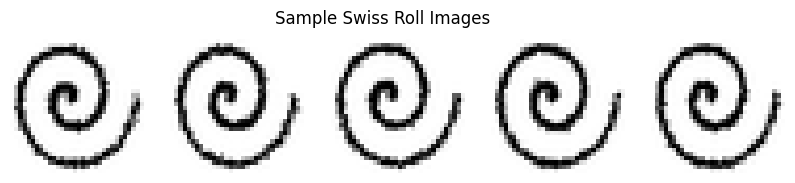

In [3]:
# Generate 100 grayscale Swiss Roll images of shape (1, 32, 32)
n_images = 100
images = torch.stack([generate_swiss_roll_image() for _ in range(n_images)])

print(f"Dataset shape: {images.shape}")  # Expected: (n_images, 1, 32, 32)

# Preview a few samples
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i, 0], cmap='gray')
    axes[i].axis('off')
plt.suptitle("Sample Swiss Roll Images ")
plt.show()

## 3. Forward SDE – Contractive Variance Preserving (CVP)

To simulate the data corruption process in score-based generative models, we rely on a forward **stochastic differential equation (SDE)** of the form:

$dX_t = f(t, X_t) \, dt + g(t) \, dB_t$

where $X_t \in \mathbb{R}^d$ is the evolving state, $B_t$ is a standard Brownian motion, and $f$, $g$ are respectively the drift and diffusion terms.

In this notebook, we implement the **Contractive Variance Preserving (CVP)** SDE, which is defined by:

$f_{\text{CVP}}(t, x) = \frac{1}{2} \beta(t) \, x$, $g_{\text{CVP}}(t) = \sqrt{\beta(t)}$

This gives the forward process:

$dX_t = \frac{1}{2} \beta(t) X_t \, dt + \sqrt{\beta(t)} \, dB_t$

To control the amount of noise added over time, we use a linear schedule for $\beta(t)$:

$\beta(t) = \beta_{\min} + \frac{t}{T} (\beta_{\max} - \beta_{\min})$


with $\beta_{\min} \ll \beta_{\max}$. This ensures a smooth and gradual corruption of the data, from $t = 0$ to $t = T$.

---

Contractive diffusion probabilistic models aim to make the sampling process more stable, especially when the estimated score function $\nabla \log p(t, x)$ is not perfect. In practice, small errors in this score can lead the reverse trajectory to drift away from the true data distribution.

To avoid this, we use a forward drift $f(t, x)$ that brings nearby points closer together over time. Mathematically, this is ensured by the monotonicity condition:

$\left\langle x - x',\ f(t, x) - f(t, x') \right\rangle \geq r_f(t) \, \|x - x'\|^2$

for all $x, x'$ and some $r_f(t) > 0$. This guarantees that the **reverse drift** will contract trajectories, making sampling more robust to approximation errors.



### Practical note

In our experiments, contractive diffusion probabilistic models such as CVP and COU both led to stable training and visually coherent generations. In this notebook, we focus on the CVP formulation for simplicity and clarity in this current setting.

The **COU process** (a time-reversed Ornstein–Uhlenbeck model) will be introduced in a separate notebook applied to MNIST.

In [4]:
# Parameters for the Contractive Variance Preserving (CVP) SDE
size = 32           # Image size (32x32)
T = 1.0             # Final time of the diffusion process
N = 10_000          # Number of discretization steps
delta = T / N       # Time step
beta_min = 0.003    # Minimum diffusion rate
beta_max = 3.0      # Maximum diffusion rate

# The parameters β_min, β_max, T, and N were chosen heuristically.
# They were not optimized but produced stable results in our experiments.

def beta(t):
    """Noise schedule increasing linearly from beta_min to beta_max."""
    return beta_min + t / T * (beta_max - beta_min)

def f_CVP(t, x):
    """Drift term of the CVP SDE: f(t, x) = 0.5 * beta(t) * x"""
    return 0.5 * beta(t) * x

def g_CVP(t):
    """Diffusion term of the CVP SDE: g(t) = sqrt(beta(t))"""
    return np.sqrt(beta(t))

## 4. Forward Process Simulation and Visualization

We now simulate the **forward diffusion** defined by the CVP SDE, starting from a clean image.

To approximate the continuous process, we use the **Euler–Maruyama scheme**, which discretizes the SDE:

$$
X_{t+\Delta t} = X_t + f(t, X_t)\, \Delta t + g(t)\, \sqrt{\Delta t} \cdot \varepsilon_t
$$

where $\varepsilon_t \sim \mathcal{N}(0, I)$ is standard Gaussian noise.

The function `sde_forward_CVP` implements this numerical integration and visualizes the evolution of the sample at regular time intervals, showing how the input is gradually corrupted by noise over time.

This helps build intuition about how score-based models learn to reverse this process during generation.

In [5]:
def sde_forward_CVP(x0, steps=10):
    """
    Simulate the forward process of the CVP SDE and display its evolution over time.

    Args:
        x0 (torch.Tensor): Initial image tensor of shape (1, size, size)
        steps (int): Number of time steps to visualize (default: 10)
    """
    xi = x0.clone()
    fig, axes = plt.subplots(1, steps + 1, figsize=(steps * 2.2, 2.5))

    # Times at which to display the image
    times_to_show = torch.linspace(0, T, steps + 1)
    show_indices = [int(t.item() / delta) for t in times_to_show]

    idx_display = 0
    for i in range(N+1):
        t = i * delta
        noise = torch.randn_like(xi)
        xi = xi + delta * f_CVP(t, xi) + g_CVP(t) * noise * np.sqrt(delta)

        if i == show_indices[idx_display]:
            img = xi[0].detach().cpu().numpy()
            axes[idx_display].imshow(img, cmap='gray')
            axes[idx_display].axis('off')
            axes[idx_display].set_title(f"t = {t:.2f}")
            idx_display += 1

    plt.suptitle("CVP SDE – Forward Process", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

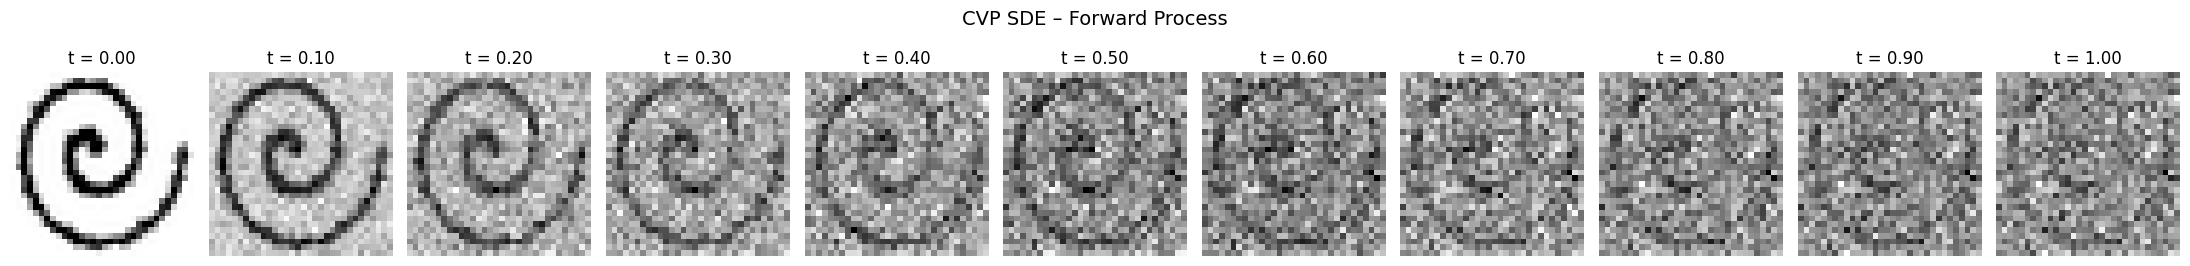

In [6]:
# Select a random image from the dataset
idx = np.random.randint(0, len(images))
sample = images[idx]

# Simulate and visualize the forward process
sde_forward_CVP(sample, steps=10)

As discussed in Section 6.3 of the research report, contractive SDEs like CVP do not fully destroy the input at time $ t = T $. The image still retains structure, which helps improve stability during generation, at the cost of a small theoretical bias.

## 5. Score Network and Training

### 5.1 U-Net Architecture for the Score Model

In score-based generative modeling, we aim to learn the score function $\nabla \log p_t(x) $ , which represents the gradient of the log-density of the data distribution at time $ t $. This function guides the reverse sampling process by pushing noisy samples back towards the data manifold.

To approximate this time-dependent score function, we use a deep neural network called the **score model**. A common and effective architecture for this task is the **U-Net**, due to its ability to capture spatial features at multiple scales.

U-Nets are particularly well-suited for image data, as they combine local and global context using a downsampling path (encoder) and an upsampling path (decoder) with skip connections.

Since the score function also depends on time $ t $, we concatenate the input image $ x $ with the time variable $ t $, which is broadcasted spatially and appended as a second channel. This allows the model to learn how the noise level varies over time.

Below is the architecture used in this notebook:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScoreNetUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the encoder (downsampling path)
        def down_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )

        # Define the decoder (upsampling path)
        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )

        # U-Net layers
        self.down1 = down_block(2, 32)      # Input: (x, t) → 32 channels
        self.down2 = down_block(32, 64)     # Downsample → 64 channels
        self.pool = nn.MaxPool2d(2)         # Max pooling (stride 2)

        self.middle = down_block(64, 128)   # Bottleneck

        self.up1 = up_block(128 + 64, 64)   # Upsample + skip from down 2
        self.up2 = up_block(64 + 32, 32)    # Upsample + skip from down 1

        self.out_conv = nn.Conv2d(32, 1, kernel_size=1)  # Final output: 1 channel (score)

    def forward(self, t ,x):
        """
        Forward pass through the U-Net score model.

        Args:
            t (torch.Tensor): Time tensor of shape (B,) or (B, 1)
            x (torch.Tensor): Noisy input image of shape (B, 1, H, W)

        Returns:
            torch.Tensor: Predicted score ∇ log p_t(x) of shape (B, 1, H, W)
        """
        B, _, H, W = x.shape

        # Broadcast t to shape (B, 1, H, W) and concatenate with x
        t = t.view(B, 1, 1, 1).expand(B, 1, H, W)
        xt = torch.cat([x, t], dim=1)  # Shape: (B, 2, H, W)

        # Encoder path
        d1 = self.down1(xt)          # (B, 32, H, W)
        d2 = self.down2(self.pool(d1))  # (B, 64, H/2, W/2)

        # Bottleneck
        mid = self.middle(self.pool(d2))  # (B, 128, H/4, W/4)

        # Decoder path with skip connections
        up1 = F.interpolate(mid, scale_factor=2, mode='bilinear', align_corners=False)
        up1 = self.up1(torch.cat([up1, d2], dim=1))  # (B, 64, H/2, W/2)

        up2 = F.interpolate(up1, scale_factor=2, mode='bilinear', align_corners=False)
        up2 = self.up2(torch.cat([up2, d1], dim=1))  # (B, 32, H, W)

        # Output
        return self.out_conv(up2)  # (B, 1, H, W)

### 5.2 — DSM Loss and Conditional Distribution of the Forward Process

To train our score-based model, we rely on the **denoising score matching (DSM)** objective. This method does not require ### 5.2 — DSM Loss and Conditional Distribution of the Forward Process

To train our score-based model, we use the **denoising score matching (DSM)** objective. This technique allows us to learn the score function $\nabla_x \log p_t(x)$, which describes the gradient of the log-probability density of noisy data at time $t$.

The DSM loss can be written in its theoretical form as:

$$
\mathcal{L}_{\text{DSM}}(\theta) =
\mathbb{E}_{t \sim \mathcal{U}(0,T)}\ 
\mathbb{E}_{X_0 \sim p_{\text{data}}(\cdot)}\ 
\mathbb{E}_{X_t \sim p(t,\cdot \mid X_0)} \left[
\lambda(t) \left\| s_\theta(t,X_t) - \nabla \log p(t,X_t \mid X_0) \right\|^2
\right].
$$

Here, the model learns to approximate the conditional score $\nabla \log p(t,X_t \mid X_0)$, the gradient of the noise distribution around each clean sample $X_0$. The function $\lambda(t)$ is a positive weighting term that may depend on time.

In practice, this loss is equivalent (up to a constant) to a more convenient form that avoids computing the exact score:

$$
\mathcal{L}_{\text{DSM}} =
\mathbb{E}_{t, X_0, \epsilon} \left[ \left\| \sigma(t) \cdot s_\theta(t, X_t) + \epsilon \right\|^2 \right],
$$

where:
- $X_0$ is a clean sample from the dataset,
- $\epsilon \sim \mathcal{N}(0, I)$ is standard Gaussian noise,
- $t \sim \mathcal{U}(0, T)$ is a time point,
- $X_t$ is sampled from $p_t(X_t \mid X_0)$,
- $\sigma(t)$ is the standard deviation of this conditional distribution.

This formulation avoids computing the true score directly, and instead trains the network to denoise corrupted samples.

To compute this loss, we must therefore be able to sample from the conditional distribution $ X_t \mid X_0 $. In the case of the CVP SDE, the forward process is defined as:

$$
dX_t = \frac{1}{2} \beta(t) X_t \, dt + \sqrt{\beta(t)} \, dB_t
$$

This SDE has a closed-form solution, which can be derived by multiplying both sides by the integrating factor:

$$
M(t) := \exp\left( -\frac{1}{2} \int_0^t \beta(s) ds \right)
$$

Using Itô’s lemma on $ M(t) X_t $, we obtain:

$$
d\left( M(t) X_t \right) = M(t) \cdot \sqrt{\beta(t)} \, dB_t
$$

Integrating both sides:

$$
M(t) X_t = X_0 + \int_0^t M(s) \cdot \sqrt{\beta(s)} \, dB_s
$$

This gives the solution:

$$
X_t = X_0 \cdot \exp\left( \frac{1}{2} \int_0^t \beta(s) ds \right) + \int_0^t \exp\left( \frac{1}{2} \int_s^t \beta(u) du \right) \cdot \sqrt{\beta(s)} \, dB_s
$$

Since the stochastic integral is Gaussian with mean zero, the conditional distribution $ X_t \mid X_0 $ is Gaussian.

We can thus compute:
- **Mean**:
$$
\mu_{\text{CVP}}(t, X_0) = X_0 \cdot \exp\left( \frac{1}{2} \int_0^t \beta(s) ds \right)
$$
- **Variance**:
$$
\sigma_{\text{CVP}}^2(t) = \int_0^t \exp\left( \int_s^t \beta(u) du \right) \cdot \beta(s) ds = \exp\left( \int_0^t \beta(s) ds \right) - 1
$$

Having these explicit formulas for the mean and variance of $X_t \mid X_0 $makes it straightforward to generate samples from the forward process, which is required to evaluate the DSM objective.


In [8]:
def integrated_beta(t):
    """Integral of the beta schedule, used for computing variance analytically."""
    return beta_min * t + 0.5 * (beta_max - beta_min) * t**2 / T

def mu_cvp(t, x0):
    """Conditional mean of X_t given X_0 under the CVP SDE."""
    return x0 * torch.exp(0.5 * integrated_beta(t).view(-1, 1, 1, 1))

def sigma_cvp(t):
    """Conditional standard deviation of X_t given X_0 under the CVP SDE."""
    return torch.sqrt(torch.exp(integrated_beta(t)) - 1.0)

In [9]:
def dsm_loss_cvp(score_model, x0s, T):
    """
    Compute the denoising score matching loss under the CVP SDE.

    Args:
        score_model: neural network approximating the score function
        x0s (torch.Tensor): batch of clean data samples
        T (float): final time of the diffusion process
    """
    B = x0s.shape[0]
    device = x0s.device
    t = torch.rand(B, device=device) * T  # sample random times
    eps = torch.randn_like(x0s)           # Gaussian noise
    sigma_t = sigma_cvp(t).view(B, 1, 1, 1)
    x_t = mu_cvp(t, x0s) + sigma_t * eps  # sample X_t | X_0

    score_pred = score_model(t,x_t)
    loss = ((sigma_t * score_pred + eps) ** 2).mean()  # DSM loss: expectation over t and noise of || sigma(t) * s_theta(t, x_t) + epsilon ||^2
    return loss

### 5.3 — Flexible Training Setup: Checkpoints, Skipping and Hugging Face

This block defines a flexible training setup that adapts to different scenarios. Depending on your needs, you can:
- **Resume** training from a local checkpoint if available;
- **Start** training from scratch if no saved model is found;
- **Skip** training entirely (e.g., for sampling only);
- **Load** a pretrained model directly from the Hugging Face Hub.

To bypass training, simply set `skip_training = True`.  
You can also use the `use_huggingface` flag to fetch a model trained elsewhere and proceed directly to sampling.

In [10]:
import os
from huggingface_hub import hf_hub_download

# ===== Options =====
use_huggingface = True   # Set to True to load model from Hugging Face
skip_training = False    # Set to True to skip training

# ===== Setup: Model, Optimizer, Scheduler =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
score_model = ScoreNetUNet().to(device)
optimizer = torch.optim.Adam(score_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)

# ===== Load Model =====
checkpoint_path = "checkpoint.pth"
start_step = 0

if use_huggingface:
    print("Loading checkpoint from Hugging Face Hub...")
    model_path = hf_hub_download(
        repo_id="Arsenecl/diffusion_model",
        filename="score_based_swiss_roll_cvp_model"
    )
    checkpoint = torch.load(model_path, map_location=device)
    score_model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_step = checkpoint.get('step', 0)
    print(f"Checkpoint loaded from Hugging Face at step {start_step}.")
elif os.path.exists(checkpoint_path):
    print("Local checkpoint found. Resuming training...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    score_model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_step = checkpoint.get('step', 0)
    print(f"Training resumed from step {start_step}.")
else:
    print("No checkpoint found. Starting training from scratch.")

# ===== Skip Training Option =====
if skip_training:
    print("Training is skipped.")
else:
    print("Training will proceed.")

Loading checkpoint from Hugging Face Hub...


score_based_swiss_roll_cvp_model:   0%|          | 0.00/5.74M [00:00<?, ?B/s]

Checkpoint loaded from Hugging Face at step 40000.
Training will proceed.


### 5.4 — Training Loop

We now run the training loop using the Denoising Score Matching (DSM) objective.

At each step:
- A random batch of images is sampled from the dataset.
- The model predicts the score $s_θ(t, x)$, and the DSM loss is computed.
- We perform a standard gradient descent update on the model parameters.
- A learning rate scheduler is applied to gradually reduce the step size.

Every 1000 steps, the model and optimizer states are saved as a checkpoint.
At the end of training, the final model is saved for future sampling.

The number of steps and batch size can be adjusted at the top of the cell.

In [11]:
batch_size = 32
num_steps = start_step + 40000  # Number of training steps to run

images = images.to(device)

for step in tqdm(range(start_step, num_steps)):
    # Sample a random batch of images
    batch_idx = torch.randint(0, len(images), (batch_size,))
    x0s = images[batch_idx]

    # Compute the denoising score matching loss
    loss = dsm_loss_cvp(score_model, x0s, T)

    # Gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Save checkpoint every 1000 steps
    if step % 1000 == 0:
        print(f"[{step}] DSM loss: {loss.item():.4f}")
        torch.save({
            'model': score_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'step': step
        }, checkpoint_path)

# Save final checkpoint at the end of training
print(f"[{num_steps}] Final model saved.")
torch.save({
    'model': score_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'step': num_steps
}, checkpoint_path)

  0%|          | 8/40000 [00:01<1:18:48,  8.46it/s] 

[40000] DSM loss: 0.2024


  1%|          | 493/40000 [00:07<10:26, 63.04it/s]


KeyboardInterrupt: 

## 6— Visualizing Sample Quality with the Reverse Process

To evaluate the quality of the samples generated by our trained score model, we implement a reverse-time SDE sampler using the **predictor-corrector scheme**. This approach combines:

- A predictor step, based on the Euler–Maruyama discretization of the time-reversed CVP SDE, which ensures the global trajectory follows the learned score.
- A corrector step, based on Langevin MCMC, which locally refines the sample to better match the target distribution at each time step.

This method is more general than a pure predictor-only Euler scheme, and typically yields sharper results. Below, we generate visualizations of intermediate steps along the reverse process, starting from pure Gaussian noise and progressively denoising the sample.

In [29]:
def run_reverse_sde_pc_cvp(score_model, shape=(1, 1, 32, 32), n_corrector=1, langevin_step_size=0.001, steps=8):
    """
    Run the predictor-corrector sampler for the reverse CVP SDE.

    Args:
        score_model: Trained neural network approximating the score function
        shape (tuple): Shape of the output sample (e.g. (1, 1, 32, 32))
        n_corrector (int): Number of Langevin corrector steps per time step
        langevin_step_size (float): Step size for Langevin MCMC
        steps (int): Number of images to display during sampling
    """
    score_model.eval()
    with torch.no_grad():
        N_steps = 1000
        delta_t = T / N_steps

        # Initial sample from Gaussian noise with same variance as final forward distribution
        std_init = torch.sqrt(torch.exp(torch.tensor(0.5 * T * (beta_max + beta_min), device=device)) - 1)
        x = torch.randn(shape, device=device) * std_init

        # Create figure with one subplot per snapshot
        fig, axes = plt.subplots(1, steps + 1, figsize=(steps * 2, 4))

        for j in range(N_steps + 1):
            # Current time (decreasing from T to 0)
            t = T - j * delta_t
            t_tensor = torch.full((shape[0],), t, device=device)

            # Get beta(t) and sigma(t) for this time step
            beta_t = beta(t)
            beta_t_tensor = torch.tensor(beta_t, device=device).view(1, 1, 1, 1)
            sigma_t = sigma_cvp(t_tensor).view(-1, 1, 1, 1)

            # Predictor step 
            score = score_model(t_tensor, x)
            noise = torch.randn_like(x)
            drift = -0.5 * beta_t_tensor * x + beta_t_tensor * score
            diffusion = torch.sqrt(beta_t_tensor + 1e-5) * noise * np.sqrt(delta_t)
            x = x + drift * delta_t + diffusion

            # Corrector step
            for _ in range(n_corrector):
                score = score_model(t_tensor, x)
                noise = torch.randn_like(x)
                x = x + langevin_step_size * score + torch.sqrt(torch.tensor(2 * langevin_step_size)) * noise

            # Save intermediate image 
            if j % (N_steps // steps) == 0:
                idx = j // (N_steps // steps)
                img = x[0, 0].cpu().numpy()
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(f"t = {t:.2f}")
                axes[idx].axis('off')

                
        plt.suptitle("Reverse Process with CVP SDE (Predictor–Corrector)")
        plt.tight_layout()
        plt.show()

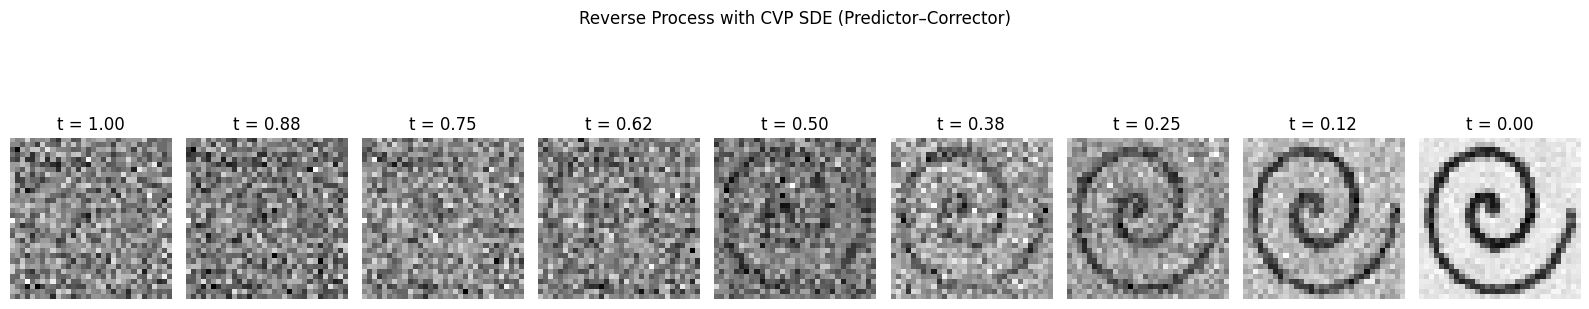

In [28]:
run_reverse_sde_pc_cvp(score_model, n_corrector = 2)

## Conclusion

In this notebook, we implemented a complete score-based generative pipeline using a synthetic 2D dataset and the Contractive VP SDE. From training a U-Net score model to generating samples via a predictor–corrector reverse process, we observed how coherent structure can gradually emerge from pure noise under the learned dynamics.

This simplified setting offered a controlled environment to validate the training and sampling mechanisms, and served as a foundation before applying the same approach to real image data.

The next step is to test these models on more complex datasets like MNIST, where we can further assess the robustness and expressiveness of contractive SDEs in more realistic scenarios.